In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import json

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.model_selection import cross_val_score
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, StratifiedKFold, RepeatedStratifiedKFold

import warnings
warnings.filterwarnings('ignore')

k_fold = 10
seed = 42
np.random.seed(seed)

In [2]:
repeated_stratify_cv = RepeatedStratifiedKFold(n_splits=k_fold, n_repeats=3, random_state=seed)

#### 1 Read and describe data

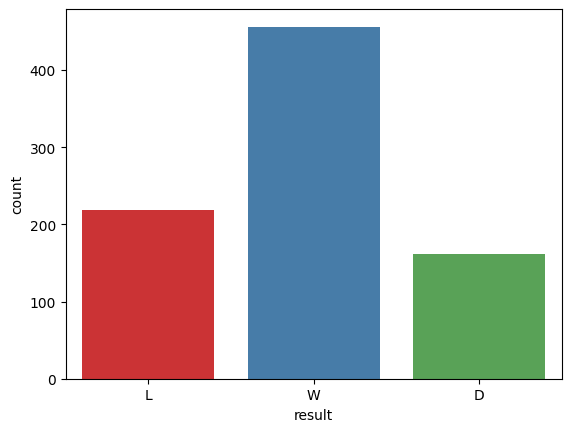

In [3]:
matches_df = pd.read_csv('data_rf.csv')
sns.countplot(x='result', data=matches_df, palette="Set1") 
matches_df.loc[matches_df["result"] == "W", "result"] = 0
matches_df.loc[matches_df["result"] == "L", "result"] = 1
matches_df.loc[matches_df["result"] == "D", "result"] = 2

## Phân chia dữ liệu

### Chia dữ liệu

In [5]:
X = matches_df.drop("result", axis=1)
y = matches_df["result"].astype("int")

In [6]:
X

,win_before_team1,win_before_team2,draw_before_team1,draw_before_team2,history_team1_lose_team2,history_team1_win_team2,history_team1_draw_team2,is_opponent_big6,venue_Home,venue_Away
0,0.000000,0.0,0.0,0.00,0.000000,0.000000,0.000000,0,0,1
1,0.000000,1.0,0.0,0.00,0.000000,0.000000,0.000000,0,1,0
2,0.500000,0.5,0.0,0.00,0.000000,0.000000,0.000000,0,1,0
3,0.333333,1.0,0.0,0.00,0.000000,0.000000,0.000000,0,0,1
4,0.500000,0.5,0.0,0.25,0.000000,0.000000,0.000000,1,0,1
...,...,...,...,...,...,...,...,...,...,...
831,1.000000,0.0,0.0,0.20,0.363636,0.454545,0.181818,0,1,0
832,1.000000,0.2,0.0,0.40,0.325581,0.465116,0.209302,0,0,1
833,1.000000,0.2,0.0,0.20,0.534884,0.372093,0.093023,1,1,0
834,1.000000,0.6,0.0,0.00,0.090909,0.909091,0.000000,0,0,1


In [7]:
# Xác định các cột phân loại và cột số
categorical_cols = X.select_dtypes(include=['object', 'category']).columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns

In [8]:
# Tạo ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        # ('cat', OneHotEncoder(handle_unknown="ignore"), categorical_cols)
    ])

### Thử nghiệm các mô hình

In [9]:
algorithms = [
    ("LR", LogisticRegression(random_state=seed)),
    (
        "SVC",
        SVC(
            probability=True,
            random_state=seed,
        ),
    ),
    ("KNN", KNeighborsClassifier()),
    ("DTC", DecisionTreeClassifier(random_state=seed)),
    ("SGDC", CalibratedClassifierCV(SGDClassifier(random_state=seed))),
    ("NB", GaussianNB()),
    (
        "RF",
        RandomForestClassifier(
            n_estimators=100,
            random_state=seed,
        ),
    ),
]

cv_results = {}
for name, model in algorithms:
    # Tạo pipeline bao gồm preprocessor và mô hình
    pipeline = Pipeline([("preprocessor", preprocessor), ("model", model)])
    
    # Thực hiện cross-validation
    cv_scores = cross_val_score(
        pipeline, X, y, cv=repeated_stratify_cv, scoring="accuracy"
    )
    cv_results[name] = cv_scores.mean()

# Hiển thị kết quả cross-validation
for name, score in cv_results.items():
    print(f"{name}: {score}")

LR: 0.5689567794989482
SVC: 0.5658060814687321
KNN: 0.5510566073819086
DTC: 0.44857047236565306
SGDC: 0.5522375215146299
NB: 0.5642522470835725
RF: 0.5306894243641233


### Thử nghiệm lại preprocessor

In [11]:
transformed_X = preprocessor.fit_transform(X)
new_columns = numerical_cols.to_list()

transformed_X = pd.DataFrame(transformed_X, columns=new_columns)
transformed_X

,win_before_team1,win_before_team2,draw_before_team1,draw_before_team2,history_team1_lose_team2,history_team1_win_team2,history_team1_draw_team2,is_opponent_big6,venue_Home,venue_Away
0,-1.875927,-1.382641,-0.956166,-1.151581,-1.359845,-1.504622,-1.109603,-0.597614,-1.0,1.0
1,-1.875927,2.380832,-0.956166,-1.151581,-1.359845,-1.504622,-1.109603,-0.597614,1.0,-1.0
2,-0.115403,0.499095,-0.956166,-1.151581,-1.359845,-1.504622,-1.109603,-0.597614,1.0,-1.0
3,-0.702244,2.380832,-0.956166,-1.151581,-1.359845,-1.504622,-1.109603,-0.597614,-1.0,1.0
4,-0.115403,0.499095,-0.956166,0.007394,-1.359845,-1.504622,-1.109603,1.673320,-1.0,1.0
...,...,...,...,...,...,...,...,...,...,...
831,1.645122,-1.382641,-0.956166,-0.224401,0.098695,0.174841,-0.106457,-0.597614,1.0,-1.0
832,1.645122,-0.629947,-0.956166,0.702779,-0.053943,0.213898,0.045182,-0.597614,-1.0,1.0
833,1.645122,-0.629947,-0.956166,-0.224401,0.785565,-0.129806,-0.596365,1.673320,1.0,-1.0
834,1.645122,0.875443,-0.956166,-1.151581,-0.995210,1.854303,-1.109603,-0.597614,-1.0,1.0


In [12]:
X = transformed_X

# Chọn bộ tham số

### SVC

In [ ]:
best_params_SVC = {}
models_tuned_SVC = {}

# Adjust your algorithms list to use descriptive names that match param_grid
algorithms = [
    ("SVC", SVC(probability=True)),
]

# Define parameter grid with correct keys
param_grid = {
    "SVC": {
        "C": [0.1, 1, 10, 50, 100, 200, 300],  # Expanded C range
        "gamma": ["scale", "auto", 0.01, 0.1, 1, 10, 20],  # More granular gamma range
        "kernel": ["linear", "poly", "rbf", "sigmoid"]  # Added kernel options
    }
}


# Randomized Search application with check for parameter grid existence
for name, model in algorithms:
    print("Model processing: ", name)
    if name in param_grid:
        randomized_search = RandomizedSearchCV(
            estimator=model, 
            param_distributions=param_grid[name], 
            n_iter=100,  # You can adjust the number of iterations
            cv=5, 
            scoring='accuracy', 
            random_state=42,
            n_jobs=-1,
            verbose=1
        )
        randomized_search.fit(X, y)
        best_params_SVC[name] = randomized_search.best_params_
        models_tuned_SVC[name] = randomized_search.best_estimator_
    else:
        print(f"No parameter grid defined for {name}")


### RF

In [ ]:
best_params_RF = {}
models_tuned_RF = {}

# Adjust your algorithms list to use descriptive names that match param_grid
algorithms = [
    ('RF', RandomForestClassifier()),
]

# Define parameter grid with correct keys
param_grid = {
    "RF": {
        "n_estimators": [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],  # More options for n_estimators
        "max_features": ["auto", "sqrt", "log2", 0.2, 0.4, 0.6],  # More granular control
        "max_depth": [int(x) for x in np.linspace(10, 110, num = 11)] + [None],  # Added max_depth
        "min_samples_split": [2, 5, 10, 20],  # Added min_samples_split
        "min_samples_leaf": [1, 2, 4, 6]  # Added min_samples_leaf
    }
}


# Randomized Search application with check for parameter grid existence
for name, model in algorithms:
    print("Model processing: ", name)
    if name in param_grid:
        randomized_search = RandomizedSearchCV(
            estimator=model, 
            param_distributions=param_grid[name], 
            n_iter=100,  # You can adjust the number of iterations
            cv=5, 
            scoring='accuracy', 
            random_state=42,
            n_jobs=-1,
            verbose=1
        )
        randomized_search.fit(X, y)
        best_params_RF[name] = randomized_search.best_params_
        models_tuned_RF[name] = randomized_search.best_estimator_
    else:
        print(f"No parameter grid defined for {name}")


### Các thuật toán khác

In [14]:
best_params_random_other = {}
models_tuned_random_other = {}

# Adjust your algorithms list to use descriptive names that match param_grid
algorithms = [
    ("LR", LogisticRegression()),
    ('KNN', KNeighborsClassifier()),
    ("DTC", DecisionTreeClassifier()),
    ("SGDC", CalibratedClassifierCV(SGDClassifier())),
    ("NB", GaussianNB()),
]

# Define parameter grid with correct keys
param_grid = {
    "LR": {
        "C": np.logspace(-4, 4, 20),  # More granular range for C
        "solver": ["liblinear", "lbfgs", "saga", "newton-cg"],  # Added 'newton-cg'
        "penalty": ["l1", "l2", "elasticnet", "none"]  # Different norms for regularization
    },
    "DTC": {
        "max_depth": [None, 3, 5, 10, 15, 20, 30, 50, 100],  # Expanded range
        "min_samples_split": [2, 5, 10, 20, 40, 100],  # More options
        "min_samples_leaf": [1, 2, 5, 10, 20]  # Added min_samples_leaf
    },
    "KNN": {
        "n_neighbors": list(range(1, 21)),  # More neighbors
        "weights": ["uniform", "distance"],  # Existing weights
        "metric": ["euclidean", "manhattan", "chebyshev", "minkowski"]  # Added distance metrics
    }
}


# Randomized Search application with check for parameter grid existence
for name, model in algorithms:
    print("Model processing: ", name)
    if name in param_grid:
        randomized_search = RandomizedSearchCV(
            estimator=model, 
            param_distributions=param_grid[name], 
            n_iter=100,  # You can adjust the number of iterations
            cv=5, 
            scoring='accuracy', 
            random_state=42,
            n_jobs=-1,
            verbose=1
        )
        randomized_search.fit(X, y)
        best_params_random_other[name] = randomized_search.best_params_
        models_tuned_random_other[name] = randomized_search.best_estimator_
    else:
        print(f"No parameter grid defined for {name}")


Model processing:  LR
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Model processing:  KNN
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Model processing:  DTC
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Model processing:  SGDC
No parameter grid defined for SGDC
Model processing:  NB
No parameter grid defined for NB


In [15]:
with open('best_params/best_params_random_other.json', 'w') as f:
    json.dump(best_params_random_other, f)

#### Thử nghiệm bộ tham số

In [19]:
algorithms_score_df = []

##### Random forest

In [20]:
with open('best_params/best_params_RF.json', 'r') as f:
    best_params_RF = json.load(f)

# Assuming 'best_params' has been filled with the best parameters for each model from GridSearchCV or RandomizedSearchCV
algorithms = [
    ('RF', RandomForestClassifier(**best_params_RF.get("RF", {}), random_state=42)),
]

cv_results = {}
for name, model in algorithms:
    cv_scores = cross_val_score(model, X, y, cv=5)  # Thực hiện cross-validation với số lượng fold là 5
    cv_results[name] = cv_scores.mean()  # Lưu kết quả trung bình của các fold

# Hiển thị kết quả cross-validation
for name, score in cv_results.items():
    algorithms_score_df.append({
        "model": name,
        "score": score
    })
    print(f"{name}: {score}")

RF: 0.5575206729398346


##### Các thuật toán khác

In [21]:
with open('best_params/best_params_random_other.json', 'r') as f:
    best_params = json.load(f)

# Assuming 'best_params' has been filled with the best parameters for each model from GridSearchCV or RandomizedSearchCV
algorithms = [
    ("LR", LogisticRegression(**best_params.get("LR", {}), random_state=42)),
    ('KNN', KNeighborsClassifier(**best_params.get("KNN", {}))),
    ("DTC", DecisionTreeClassifier(**best_params.get("DTC", {}), random_state=42)),
    ("SGDC", CalibratedClassifierCV(SGDClassifier(**best_params.get("SGDC", {})))),
    ("NB", GaussianNB()),  # GaussianNB không có tham số cụ thể để điều chỉnh
]

cv_results = {}
for name, model in algorithms:
    cv_scores = cross_val_score(model, X, y, cv=5)  # Thực hiện cross-validation với số lượng fold là 5
    cv_results[name] = cv_scores.mean()  # Lưu kết quả trung bình của các fold

# Hiển thị kết quả cross-validation
for name, score in cv_results.items():
    algorithms_score_df.append({
        "model": name,
        "score": score
    })
    print(f"{name}: {score}")

LR: 0.5635300826917593
KNN: 0.5826276019389791
DTC: 0.5312660393498716
SGDC: 0.5466780724265754
NB: 0.5635443398916452


In [24]:
df = pd.DataFrame(algorithms_score_df)
df.sort_values(by="score", ascending=False)


,model,score
2,KNN,0.582628
5,NB,0.563544
1,LR,0.563530
0,RF,0.557521
4,SGDC,0.546678
3,DTC,0.531266


#### Vẽ ma trận nhầm lẫn của model có độ chính xác cao nhất 

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

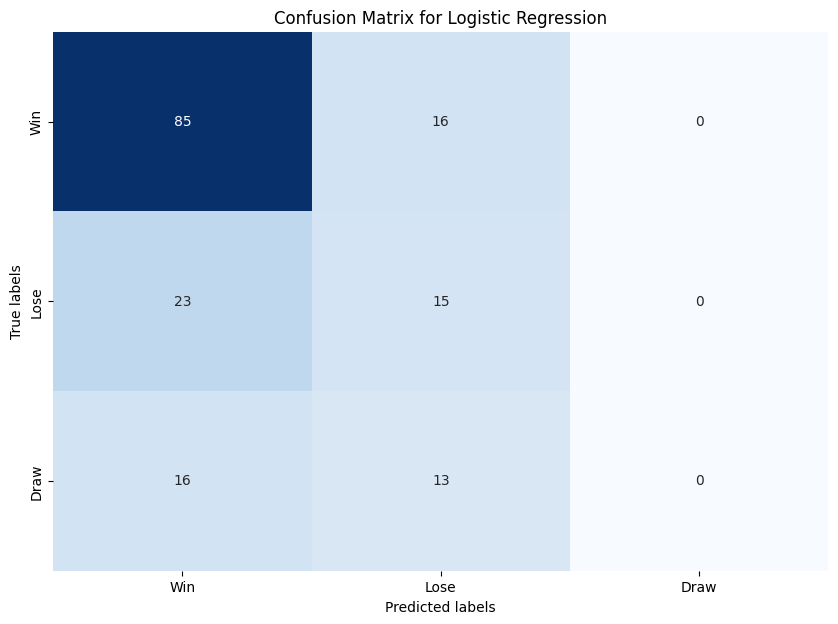

In [26]:
y_pred = models_tuned_random_other["LR"].predict(X_test)
# Tạo ma trận confusion
cm = confusion_matrix(y_test, y_pred)

# Định nghĩa nhãn cho các trục tương ứng với các lớp của 'Result'
labels = ['Win', 'Lose', 'Draw']

df_cm = pd.DataFrame(cm, index=labels, columns=labels)

# Vẽ ma trận confusion với nhãn cụ thể
plt.figure(figsize=(10, 7))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Logistic Regression')
plt.show()